# <div align="center"><b> APSERa Simulation Pipeline </b></div>


## **<div align="center"><b> Importing required packages </b></div>**


In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem
from scipy.signal import correlate

from scipy.optimize import curve_fit

%matplotlib inline
from pygsm import GlobalSkyModel


from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-u7ja2lb6 because the default path (/home/linux2/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## **<div align="center"><b> Time and number of spectra </b></div>**


In [2]:
start_time_in_UTC = '2012-05-19 05:45:00'
n_spectra = 1                  #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2012-05-19 05:45:00.000']


## **<div align="center"><b> Antenna beam </b></div>**


[2.31  2.315 2.317 2.32  2.325 2.33  2.334 2.335 2.34  2.345 2.35  2.351
 2.355 2.36  2.365 2.368 2.37  2.375 2.38  2.385 2.39  2.395 2.4   2.402
 2.405 2.41  2.415 2.419 2.42  2.425 2.43  2.435 2.436 2.44  2.445 2.45
 2.453 2.455 2.46  2.465 2.47  2.475 2.48  2.485 2.487 2.49  2.495 2.5
 2.504 2.505 2.51  2.515 2.52  2.521 2.525 2.53  2.535 2.538 2.54  2.545
 2.55  2.555 2.56  2.565 2.57  2.572 2.575 2.58  2.585 2.589 2.59  2.595
 2.6   2.605 2.606 2.61  2.615 2.62  2.623 2.625 2.63  2.635 2.64  2.645
 2.65  2.655 2.657 2.66  2.665 2.67  2.674 2.675 2.68  2.685 2.69  2.691
 2.695 2.7   2.705 2.708 2.71  2.715 2.72  2.725 2.73  2.735 2.74  2.742
 2.745 2.75  2.755 2.759 2.76  2.765 2.77  2.775 2.776 2.78  2.785 2.79
 2.793 2.795 2.8   2.805 2.81  2.815 2.82  2.825 2.827 2.83  2.835 2.84
 2.844 2.845 2.85  2.855 2.86  2.861 2.865 2.87  2.875 2.878 2.88  2.885
 2.89  2.895 2.9   2.905 2.91  2.912 2.915 2.92  2.925 2.929 2.93  2.935
 2.94  2.945 2.946 2.95  2.955 2.96  2.963 2.965 2.97  2

Processing frequency 2.416 GHz
Processing frequency 2.432 GHz
Processing frequency 2.448 GHz
Processing frequency 2.464 GHz
Processing frequency 2.48 GHz
Processing frequency 2.496 GHz
Processing frequency 2.512 GHz
Processing frequency 2.528 GHz
Processing frequency 2.544 GHz
Processing frequency 2.56 GHz
Processing frequency 2.576 GHz
Processing frequency 2.592 GHz
Processing frequency 2.608 GHz
Processing frequency 2.624 GHz
Processing frequency 2.64 GHz
Processing frequency 2.656 GHz
Processing frequency 2.672 GHz
Processing frequency 2.688 GHz
Processing frequency 2.704 GHz
Processing frequency 2.72 GHz
Processing frequency 2.736 GHz
Processing frequency 2.752 GHz
Processing frequency 2.768 GHz
Processing frequency 2.784 GHz
Processing frequency 2.8 GHz
Processing frequency 2.816 GHz
Processing frequency 2.832 GHz
Processing frequency 2.848 GHz
Processing frequency 2.864 GHz
Processing frequency 2.88 GHz
Processing frequency 2.896 GHz
Processing frequency 2.912 GHz
Processing freq

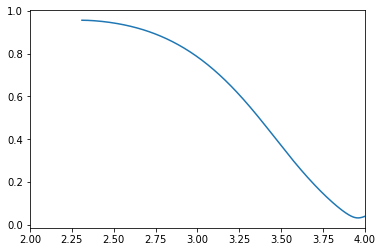

In [3]:
import os
import glob
import numpy as np
from scipy import interpolate

## In the rt_file, mention the filename of S11. Please check if it is in linear form. 

beam_path = "/home/linux2/Downloads/Farfield/farfield_finite/140mm_ground"            
rt_file    = 'dipole_correct.txt'
file_list  = sorted(glob.glob(os.path.join(beam_path,"*farfield*.txt")))
#print(file_list)



gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[2:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)
gamma_val=10**(gamma_val/20)

print(gamma_freq)
print(gamma_val)
gamma_func = interpolate.interp1d(gamma_freq, gamma_val)


## This below print statement is to verify our interpolation. print(gamma_func(any freq value)) 
## and check if it matches the value in the file
#print(gamma_func(2.8))


## The below code is for the beam definition. Please make sure to check the beam_def function before proceeding

phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 360, phi_res)
theta_array = np.arange(90, -90-theta_res, -theta_res) 
freq_array  = []
file_array  = []

def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('farfield','').replace('(f=','').replace(')','').replace('[1]','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
print(get_freq_from_file('farfield(f=2.608)[1].txt'))
    
np.testing.assert_array_equal(file_array, file_list)

freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {} GHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = 90-all_val[0] 
            phi     = all_val[1]
            beam    = all_val[2]
           # print(theta)
            

            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = 10**(beam/10)
            


beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

#print(beam_3D_unnorm[0, :,:].shape)


for ifreq in range(beam_3D.shape[0]):
    for itheta in range(beam_3D.shape[1]):
        for iphi in range(beam_3D.shape[2]):
            beam_3D[ifreq, itheta,iphi] = beam_3D_unnorm[ifreq, itheta,iphi]/np.amax(beam_3D_unnorm[ifreq,:,:])


print(freq_array)    

        
theta_array_new = np.flip(theta_array)
phi_array_new   = phi_array
beam_3D_flip=np.flip(beam_3D,axis=1)
#print(beam_3D_flip[2,:,0],beam_3D[2,:,0])
from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((freq_array, theta_array_new,
                                                     phi_array_new), beam_3D_flip)
#print(my_interpolating_function.shape)



## Beam definition
## If only the effect of S11 has to be checked (with ideal antenna beam), use the sin^(theta) beam. 



def beam_def(freq, alt, az):
    return float(my_interpolating_function([freq, alt, az]))
    #if (alt<=0):
     #   return 0
    #else:
     #   return (math.sin(alt*PI/180)*math.sin(alt*PI/180))


    
plt.plot(gamma_freq, gamma_val)
plt.xlim([2,4])
plt.show()

## **<div align="center"><b> Definitions </b></div>**


[2h55m09.6725s]
0.007438750629075668


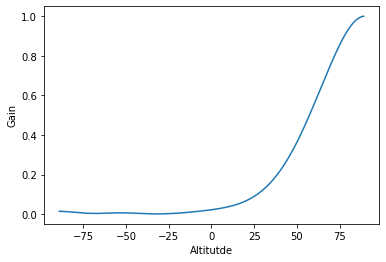

In [6]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2.5                  #Check the f_start and f_stop and change the number of channels accordingly
f_stop = 4
No_of_Channels = 251
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 13.067439
longitude =80.237617            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 3e+13
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R



Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)
plt.xlabel('Altitutde')
plt.ylabel('Gain')
plt.plot(theta_array_new[1:180],beam_3D_flip[50,1:180,0])
print(beam_def(2.8,-70,0))
#plt.plot(beam_3D[100,1:90,0])

## <div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [7]:
gsm = GlobalSkyModel(freq_unit='GHz')

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

print("Got P_dif for calibration!")

sky_1420 = hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, N_SIDE)

sky_408 = hp.ud_grade(((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB, N_SIDE)

sky_23000 = hp.ud_grade((np.loadtxt('23000MHz_Sky_map.txt')/1000), N_SIDE)

print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!")

Got CMB Int!
Got P_dif for calibration!
Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!


## <div align="center"><b> Getting recombination lines </b></div>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


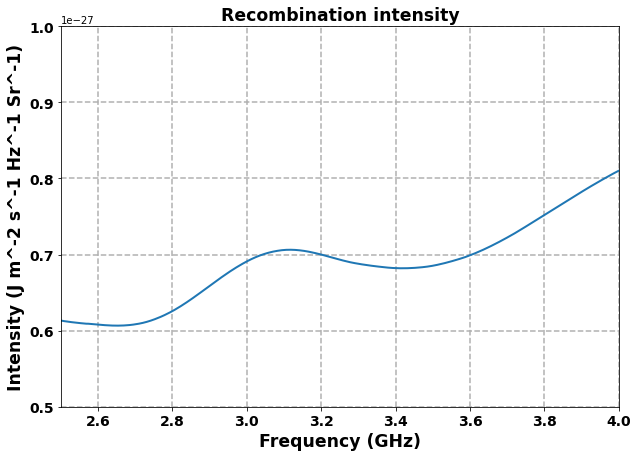

In [8]:


df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.figure(figsize=(10, 7))
plt.plot((df['Frequency']), (df['Intensity']),linewidth=2)
plt.title('Recombination intensity', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)



## <div align="center"><b> Getting spectra </b></div>


In [ ]:

t = 0
while t<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
      
        #Using power law relation to fit spectra of three frequency maps
        def func(xx, a):
            return (sky_408)[i-1] * np.power((xx/0.408), a) 

        xx = np.array([0.408, 1.420, 23])
        yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

        popt, pcov = curve_fit(func, xx, yy)
        

        #print(freqs)
        j=0
        longitudes = equi.az.value
        while j< No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def(freqs[j], new_alt, longitudes)
           # print(new_alt,cwt)
            if (cwt>0):     #Adding all the three intensities

                map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)
                Power = (map_1 + CMB_Int[j]+Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) #+Rec_int[j]
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                
                cross_real[j] = cross_real[j] + cwt*final_temp* (1 - np.power(gamma_func(freqs[j]),2))
                
                ## Remove the (1 - np.power(gamma_func(freqs[j]),2)) to try for ideal antenna (no return loss
                
                sumwt[j] = sumwt[j]+ cwt
            
            j = j+1
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i = i+1

    
    i=0    
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    
    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0,1,No_of_Channels)

    #Adding the gaussian error
    
    cross_real = cross_real + array*sigma       
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions
                                                    
    cross_imag = cross_imag + array*sigma
    
    spectra[t] = cross_real
    spectra_cross_imag[t] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels
    
    print("No. of spectra got = ", t+1)
    
    t = t+1

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s'%lst[0])
plt.grid()
plt.show()


In [ ]:


print(np.shape(spectra))

plt.figure(figsize=(10, 7))
plt.plot(freqs, spectra[0],linewidth=2)
plt.xlabel('Frequency [GHz]', fontsize='xx-large', fontweight='bold')
plt.ylabel('Temperature [K]', fontsize='xx-large', fontweight='bold')
plt.title('Simulated Sky Spectrum at one LST', fontsize='xx-large', fontweight='bold')
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')

plt.show()

## <div align="center"><b> Fitting with MS_fit function: CMB + smooth fit </b></div>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import random as rndm
from math import exp, expm1, sqrt
from math import factorial as mf
from scipy.optimize import fmin
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages

PI=scipy.constants.pi
HH=scipy.constants.h
KK=scipy.constants.k
HbK=HH/KK
HbK9=HbK*1.0e9

## Please check the range of frequencies you are working with. Change the x1 and x2 accordingly

X1 = 2.5
X2 = 4
print (' ')
print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

X1LOG = np.log10(X1)
X2LOG = np.log10(X2)
XDIF = X1LOG-X2LOG

np.set_printoptions(precision=20)

In [ ]:
func1 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 \
						  )

func2 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2  \
						  )

func3 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3  \
						  )

func4 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4  \
						  )

func5 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5  \
						  )

func6 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6  \
						  )

func7 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7  \
						  )
func8 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8)

func9 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9)

func10 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10)	

func11 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11)

func12 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11+ \
					(p[13])*(np.log10(x)-X1LOG)**12)	

# define the function to be minimized by scipy.optimize.fmin
chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

def chisq3 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

def chisq4 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))
	
def chisq5 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))
	
def chisq6 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

def chisq7 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

def chisq8 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

def chisq9 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

def chisq10 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
		(mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
		(mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
	    (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
	k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))

In [ ]:
residuals = []
x0 = freqs
x0 = np.asfarray(x0)
x0log = np.log10(x0)


low=0.05
high=10


i_low=0
i_high=len(x0)
for i in range(0, len(x0)):
	if x0[i]<=low:
		i_low=i
	if x0[i]<=high:
		i_high=i
print("Limits in index: ",i_low,i_high)
x1=x0[i_low:i_high]
x1log = np.log10(x1)
X1=(x1log[0])
print(x1log.size)


In [ ]:
x1 = x0
x1log = np.log10(x1)


y1 = np.array(spectra)
print(y1.size)

## Here, we can just choose to fit the spectrum we have (without beam correction). For that, uncomment the below line
#y1log = np.log10(y1)


## Alternatively, we can correct for the S11, by fitting the gamma value and correcting the spectrum. For that, uncomment the below 4 lines 
gamma_val_for_freqs = gamma_func(freqs)
p = np.polyfit(freqs, 1 - np.power(gamma_val_for_freqs,2),50)
gamma_val_fit = np.polyval(p, freqs) 
#for ii in range(0,12):  ## averaging spectrum over 12 spectra
y1 = np.divide(spectra[0], gamma_val_fit)
    
#y1ave=np.average(y1,axis=0)
#print(y1ave.shape)

#y1 = np.divide(spectra, gamma_val_fit)

## Use one of the above at a time


#plt.plot(y1ave)
#plt.show()
plt.plot(y1)
y1log = np.log10(y1)

print('Check if the graph plotted looks smooth if beam correction is done')

In [ ]:
		p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
		yfit_poly = p12(x1log)
		yres_poly = (10.0**yfit_poly) - y1
		#plt.figure()
		#plt.grid()
		#plt.xlabel('Freq [MHz]')
		#plt.ylabel('res Temp [K]')
		#plt.plot(x1*1.0e3,yres_poly,lw=2)
        #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
		#plt.title('Polyo10 residual spec %s'%(i))
		# plt.show()
		#pdf.savefig()
		#plt.close()
		# Initial guess for optimization				
		p00 = [np.log10(3.0),1.0,-2.5] 
		
		p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		current_chisq = chisq1(p1,x1,y1)
		print (" ")
		print ("chisq1 = ",current_chisq)
		print (10.0**p1[0], p1[1], p1[2])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],0.0] 
		p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq2(p1,x1,y1)
		print (" ")
		print ("chisq2 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
		p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq3(p1,x1,y1)
		print (" ")
		print ("chisq3 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
		p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq4(p1,x1,y1)
		print (" ")
		print ("chisq4 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
		p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq5(p1,x1,y1)
		print (" ")
		print ("chisq5 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
		p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq6(p1,x1,y1)
		print (" ")
		print ("chisq6 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
		p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq7(p1,x1,y1)
		print (" ")
		print ("chisq7 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
		print (" ")
				
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
		p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq8(p1,x1,y1)
		print (" ")
		print ("chisq8 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])
		
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
		p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq9(p1,x1,y1)
		print (" ")
		print ("chisq9 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])
			
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
		p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq10(p1,x1,y1)
		print (" ")
		print ("chisq10 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
		print (" ")

		yfit = func10(p1,x1)
		yres = y1 - yfit
		#residuals.append(yres) 
		# scale = 0.03/chisq12(p1,x1,y1)
		# y2 = yfit + scale*(1.0e5**yres)
		yfitlog=np.log10(yfit)
        
residuals = np.asfarray(residuals)
print(residuals)

sp1 = y1 -yfit

plt.plot(freqs, sp1)
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (GHz)')
plt.title('Residual after fitting with a smooth function')
plt.show()

In [ ]:
sp1 = y1 -yfit

#plt.plot(freqs, sp1)
#plt.ylabel('Temperature (K)')
#plt.xlabel('Frequency (GHz)')
#plt.title('Residual after fitting with a smooth function')
#plt.show()
plt.figure(figsize=(10, 7))
plt.plot(freqs, sp1* 1e+03, linewidth=2.0)
plt.ylabel('Temperature (mK)', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()
plt.show()
#print(sp1*1e+3)


In [ ]:
import numpy as np
import os
import sys
PATH = '/home/linux2/Downloads/msfitcodes/'
file = 'ms_fit_joint_inf'
sys.path.insert(1, PATH)
from misc import RMS_data

rms=RMS_data(np.ones(len(sp1)), sp1)
print(rms*1e3,'mK')


import numpy as np
zipped=np.column_stack([freqs,sp1,y1,spectra[0]])
#zipped=np.column_stack([spectra])
datafile_path = "/home/linux2/Downloads/Farfield/farfield_finite/140mm_ground/residues_final.txt"
np.savetxt(datafile_path , zipped)




2.8920000000000003
rms 0.026414138867619487


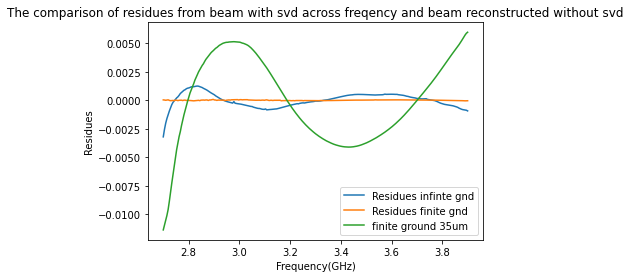

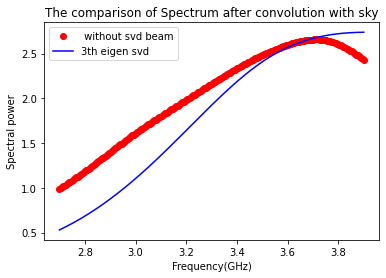

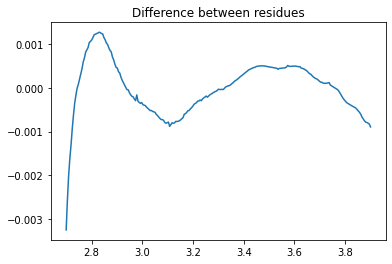

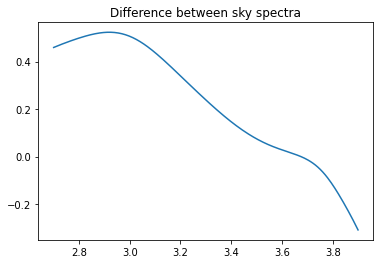

In [45]:
## this cell is just for comparing other residues This need not be run 

from misc import RMS_data
res1,spectra1=np.loadtxt("/home/linux2/Downloads/Farfield/Farfield_infinite ground/ff/residues.txt",usecols=(1,2),unpack=True)
res2,spectra2=np.loadtxt("/home/linux2/Downloads/Farfield/farfield_finite/140mm_ground/residues.txt",usecols=(1,2),unpack=True)
#sp1,spectra[0]=np.loadtxt("/home/linux2/Downloads/Farfield/svd/5theigen/residues5theigen.txt",usecols=(1,2),unpack=True)
plt.plot(freqs,res1)
plt.plot(freqs,sp1)
plt.plot(freqs,res2)
plt.xlabel('Frequency(GHz)');
plt.ylabel('Residues');
plt.legend(['Residues infinte gnd','Residues finite gnd','finite ground 35um'])
plt.title('The comparison of residues from beam with svd across freqency and beam reconstructed without svd')

plt.figure()
plt.plot(freqs,spectra1,'ro')
plt.plot(freqs,spectra[0],'b-')
plt.xlabel('Frequency(GHz)');
plt.ylabel('Spectral power');
plt.legend([' without svd beam','3th eigen svd'])
plt.title('The comparison of Spectrum after convolution with sky')

difference1=res1-sp1
difference2=spectra1-spectra[0]

plt.figure()
plt.plot(freqs,difference1)
plt.title('Difference between residues')


plt.figure()
plt.plot(freqs,difference2)
plt.title('Difference between sky spectra')
print(freqs[40])
rms_dat=rms = RMS_data(np.ones(len(sp1[40:251])), sp1[40:251])
print("rms",rms_dat*1000)